In [2]:
#change the folder to your default installation folder
folder = '/Users/matteoferro/Library/Python/3.9/lib/python/site-packages/pyetc/'

from pyetc import *
import os
import matplotlib.pyplot as plt
from astropy import constants
#from astropy import constants



#this is a package of mine for plot quality, comment it and the following row in case you use this notebook 
from setplot import set_plot_style
set_plot_style()

# LOGGING

- When you create an object of the WST class (which inherits methods of the ECT one) the _ _init_ _ from WST is used

        def __init__(self, log=logging.INFO, skip_dataload=False):
            self.refdir = CURDIR` #set the directory to the one where the data are stored
            self.version = __version__` #version from version.py
            setup_logging(__name__, level=log, stream=sys.stdout) # #
            self.logger = logging.getLogger(__name__) #all the info is saved here
            self.logger.propagate = False #not passing the log to higher levels
            
this overwrites the constructor of ETC, you can set the logging status, the main logging status which have sense is **INFO** since it stores all the relevant information from the WST, we can also use **DEBUG** which still prints the **INFO** + other `self.logger.debug` used in the main ETC code

    # # function from the **Muse Python Data Analysis Framework**: it sets a name for the logger which is the name of the module (WST), then the level (INFO) in this case, the stream is the terminal, or console


---
- #### Now we create a default object:
we can change the logging level, in case of higher level (`WARNING`, `ERROR`, `CRITICAL`), all the prints of lower levels (in this case the _info_, available trough the `get_info` method, wont be available

There is another parameter `skip_dataload` that can be set to `True` if not the default is to not skip the load and it calls for every pair of instrument and channel the `get_data` function taking data also from the `CURDIR` directory, in particular it adds the following parameters:
- 'wave': `ins['wave'] = WaveCoord(cdelt=ins['dlbda'], crval=ins['lbda1'], cunit=u.angstrom)` from `mpdaf`, is basically a dictionary in a WCS Keywords format, it has specifically:
             Number of WCS axes: 1 since it's only wavelength
             CTYPE : 'LINEAR'
             CRVAL : 6000.0  value of the reference pixel
             CRPIX : 1.0  reference pixel
             PC1_1  : 1.0  rotation (1 means it's horizontal)
             CDELT : 0.97  scaling (in this example 1 pixel is 0.97 Angstrom)
             NAXIS : 0  0, 
             ###############
             this last should be set to 0 and number of pixels for the wavelength 
             but I'm not completely sure, probably not important
             ###############
This object does not have specifically an end, but could have in principle only the initial wavelength and the step, the end is defined by the size of the flux/trans/emi used in the `mpdaf.Spectrum` object


- 'sky' 
- 'instrans'
- 'skys'
- 'chan'
- 'name': takes this directly as a parameter, e.g. `get_data(self.ifs, chan, 'ifs', CURDIR) `
- ...

    The other are reported here: https://pyetc-wst.readthedocs.io/en/latest/tutorial.html

In [3]:
obj_WST = WST(log = 'DEBUG', skip_dataload = False)

here you see the print to console of the `INFO` logging if you are logged in the right way

This is available through the `info` method of WST class which relies on the _  _info_ from ETC class:

    def _info(self, ins_names, full=False)

where `ins_names` are **['ifs', 'moslr', 'moshr']** 

The full is to print also the information regarding the `sky` and `moon`


In [4]:
#obj_WST.info(full = True)

## INSTRUMENT DATA STRUCTURE

There are:
- the 2 channels for the IFS
- the 3 for the MOS LR
- the 4 for the MOS HR
---
Going on with the data structure of the WST object, let's look at the `get_data` we were looking before, let's see what's in the files that are loaded as `tab = Table.read(fname, unit_parse_strict="silent")`


you can do it directly below:

In [5]:
#check with ESO skycalc to not use local database ! ! ! 
#https://skycalc-ipy.readthedocs.io/en/stable/GettingStarted.html#a-basic-skycalc-query

fname = '/Users/matteoferro/Library/Python/3.9/lib/python/site-packages/pyetc/data/WST/ifs_red_brightsky_1.2.fits'
tab = Table.read(fname, unit_parse_strict="silent") 

#"silent" means that if a unit string cannot be parsed, 
#Astropy will just ignore it without raising an error or warning.

display(tab[:5])

lam,flux,dflux1,dflux2,trans,dtrans1,dtrans2,flux_sml,flux_ssl,flux_zl,flux_tie,flux_tme,flux_ael,flux_arc,trans_ma,trans_o3,trans_rs,trans_ms
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
600.0,3784.0077862345156,38.34151115929752,38.34151115929752,0.6007221026594367,0.0,0.0,3656.065574719791,4.274895185156112,34.910028026354425,0.0,0.0,1.2819412515795536e-13,88.75728830321167,0.6870081677453106,0.6591075371258439,0.6477208770133244,0.6666835514226435
600.097,5104.910375943149,51.77719934682653,51.77719934682653,0.8112142473378763,0.0,0.0,4932.180784617351,5.7732758563225355,47.10221546776422,0.0,0.0,0.0013263295993318673,119.85277367211081,0.9277184686436073,0.890149494538644,0.8748005775639618,0.9003938717852492
600.194,5448.597374506749,55.35124289866819,55.35124289866819,0.8670238111035505,0.0,0.0,5263.983257189456,6.17127485523823,50.2802758875434,0.0,0.0,0.07187605559434507,128.09069051891655,0.9915198389918622,0.9511894804655449,0.9348351939914228,0.9621579339804425
600.291,5480.737309926208,55.98748330383549,55.98748330383549,0.8732765399840025,0.0,0.0,5293.339544629638,6.216710543925326,50.57139552004439,0.0,0.0,1.603978772841092,129.0056804597603,0.9986544987706972,0.9578050791820257,0.9414012190303834,0.9688850575426105
600.388,5487.177011216463,58.034346112878595,58.034346112878595,0.8736324340132035,0.0,0.0,5286.648531793291,6.220159209946433,50.51910279446419,0.0,0.0,14.739902222490729,129.04931519627263,0.9990534224371573,0.9580661261583967,0.9417309138715749,0.9691929660793388


Most of the explanations are in the **metadata** of the table (that you can see below), the metadata are compared then to what you take from the **instrument** and **channel** to check for consistency 

There is also a bound (`lbda1`, `lbda2`) and error length (`dlbda`) check of the lambda from the .fits and the ones stored in the WST class for each instrument/channel (tolerance for the error is 0.01: `tab['lam'][1]-tab['lam'][0])*10 - ins['dlbda']>0.01`)


###############

Beware that the `d['emi'] = Spectrum(data=tab['flux'], wave=ins['wave'])` does not directly store the unit of the `data`, we know from the `tab.meta` that for `tab['flux']` (e.g.) this should be ***ph/s/m2/micron/arcsec2*** so this could be passed as `d['emi'] = Spectrum(data=tab['flux'], wave=ins['wave'], unit = u.photon / u.s / u.m**2 / u.micron / u.arcsec**2)`

###############

Below plot to see how some of them looks (as a function of lambda mainly)

In [6]:
#tab.meta

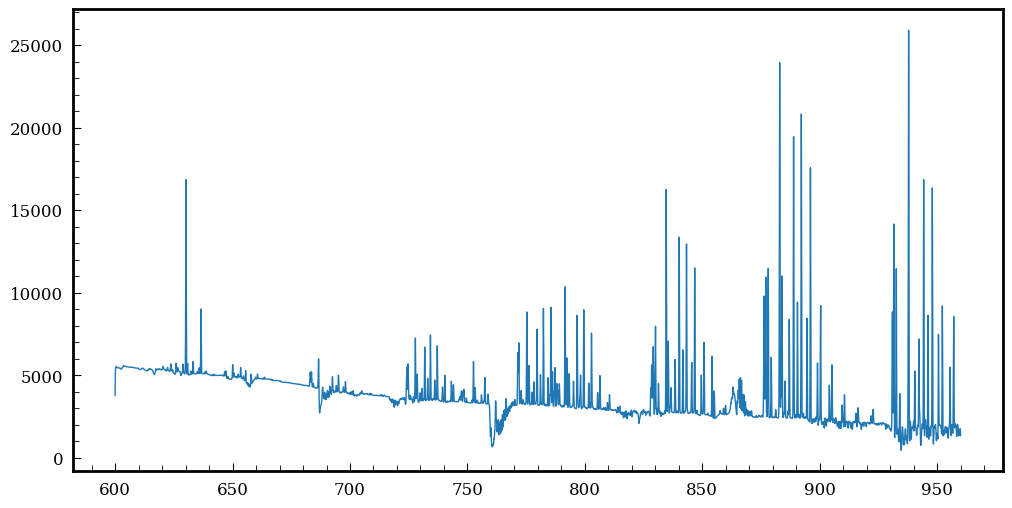

In [7]:
plt.plot(tab['lam'],tab['flux']);

- After all the sky configurations (moon + airmass) you load the atmosferic transmission, in `get_data` as:
        
        filename = f'{name}_{chan}_noatm.fits
        trans=Table.read(os.path.join(refdir,filename), unit_parse_strict="silent")


Lastly also the instrument transmissions are saved from the `{ins}_{chan}_noatm.fits`, after checking that the values of the table from the fits are inside the edges defined by `lbda1` and `lbda2` from the original dictionary

This is done with:

    ins['instrans'] = Spectrum(data=np.interp(ins['sky'][0]['emi'].wave.coord(),trans['WAVE']*10,trans['TOT']), wave=ins['sky'][0]['emi'].wave)
    
Where we save in the dictionary the `instrans` key as a MPDAF spectrum object starting from the transmission in the fits file computed at the wavelength of the emission of the first sky configuration we take into account 


###############

A bit redundant: doesn't really matter since the wavelengths of all the sky configurations for a specific instrument&channel are the same, we should have a single `lam` in a common tab I guess

###############


#### Here below you can se what's inside the WST object selecting instrument&channel

In [8]:
#change instrument and channel to see all the dictionaries, you will see that the Spectrum from in 'emi'
#are lacking the unit

obj_WST.ifs['red']

{'desc': 'Inspired from MUSE throughput',
 'version': '0.1 10/02/2023',
 'type': 'IFS',
 'obscuration': 0.18,
 'iq_fwhm': 0.1,
 'iq_beta': 2.5,
 'spaxel_size': 0.25,
 'dlbda': 0.97,
 'lbda1': 6000,
 'lbda2': 9600,
 'lsfpix': 2.5,
 'ron': 3.0,
 'dcurrent': 3.0,
 'wave': WCS Keywords
 
 Number of WCS axes: 1
 CTYPE : 'LINEAR'  
 CRVAL : 6000.0  
 CRPIX : 1.0  
 PC1_1  : 1.0  
 CDELT : 0.97  
 NAXIS : 0  0,
 'sky': [{'moon': 'brightsky',
   'airmass': 1.0,
   'emi': <Spectrum(shape=(3712,), unit='', dtype='>f8')>,
   'abs': <Spectrum(shape=(3712,), unit='', dtype='>f8')>,
   'filename': '/Users/matteoferro/Library/Python/3.9/lib/python/site-packages/pyetc2/data/WST/ifs_red_brightsky_1.0.fits'},
  {'moon': 'brightsky',
   'airmass': 1.2,
   'emi': <Spectrum(shape=(3712,), unit='', dtype='>f8')>,
   'abs': <Spectrum(shape=(3712,), unit='', dtype='>f8')>,
   'filename': '/Users/matteoferro/Library/Python/3.9/lib/python/site-packages/pyetc2/data/WST/ifs_red_brightsky_1.2.fits'},
  {'moon': 'b

There are a few more instrumental parameter which can be computed through handy functions, one is the spectral resolution with `get_spectral_resolution()`:

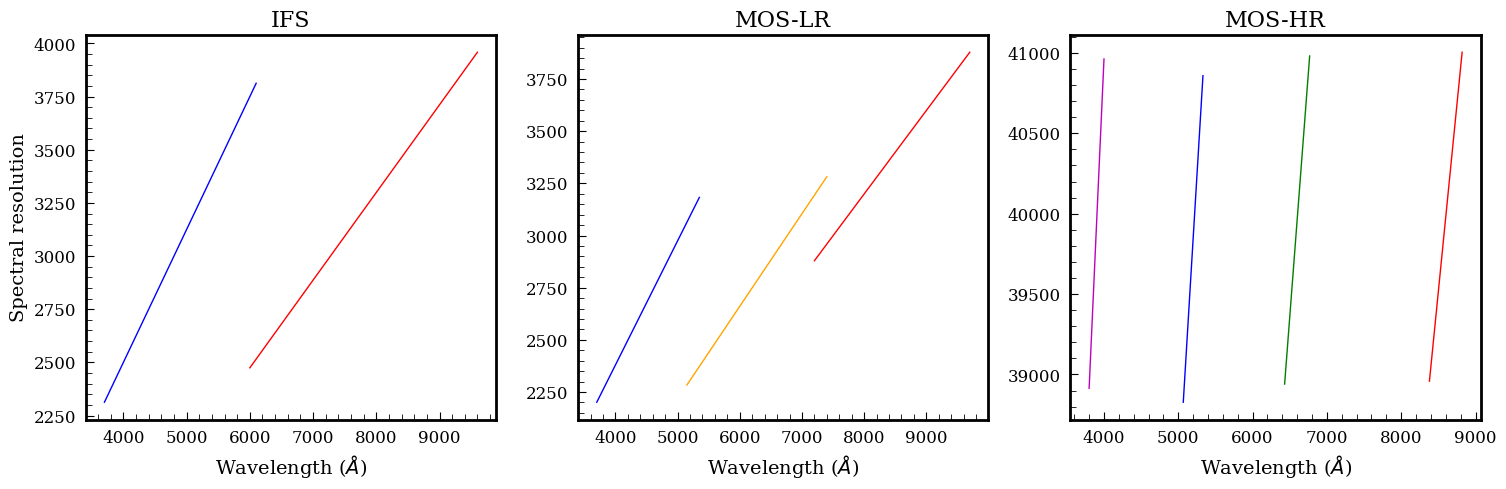

In [9]:
fig,ax = plt.subplots(1,3,figsize=(18,5))
ax[0].plot(obj_WST.ifs['blue']['wave'].coord(), obj_WST.get_spectral_resolution(obj_WST.ifs['blue']), color='b')
ax[0].plot(obj_WST.ifs['red']['wave'].coord(), obj_WST.get_spectral_resolution(obj_WST.ifs['red']), color='r')
ax[1].plot(obj_WST.moslr['blue']['wave'].coord(), obj_WST.get_spectral_resolution(obj_WST.moslr['blue']), color='b')
ax[1].plot(obj_WST.moslr['orange']['wave'].coord(), obj_WST.get_spectral_resolution(obj_WST.moslr['orange']), color='orange')
ax[1].plot(obj_WST.moslr['red']['wave'].coord(), obj_WST.get_spectral_resolution(obj_WST.moslr['red']), color='r')
ax[2].plot(obj_WST.moshr['U']['wave'].coord(), obj_WST.get_spectral_resolution(obj_WST.moshr['U']), color='m')
ax[2].plot(obj_WST.moshr['B']['wave'].coord(), obj_WST.get_spectral_resolution(obj_WST.moshr['B']), color='b')
ax[2].plot(obj_WST.moshr['V']['wave'].coord(), obj_WST.get_spectral_resolution(obj_WST.moshr['V']), color='g')
ax[2].plot(obj_WST.moshr['I']['wave'].coord(), obj_WST.get_spectral_resolution(obj_WST.moshr['I']), color='r')


ax[0].set_xlabel('Wavelength ($\AA$)')
ax[1].set_xlabel('Wavelength ($\AA$)')
ax[2].set_xlabel('Wavelength ($\AA$)')
ax[0].set_ylabel('Spectral resolution')
ax[0].set_title('IFS')
ax[1].set_title('MOS-LR')
ax[2].set_title('MOS-HR');

Below you see plots for the transmission of telescope + instrument (which are stored in the `instrans` keyword),  
basically the ratio between light entering the system and reaching the detector:

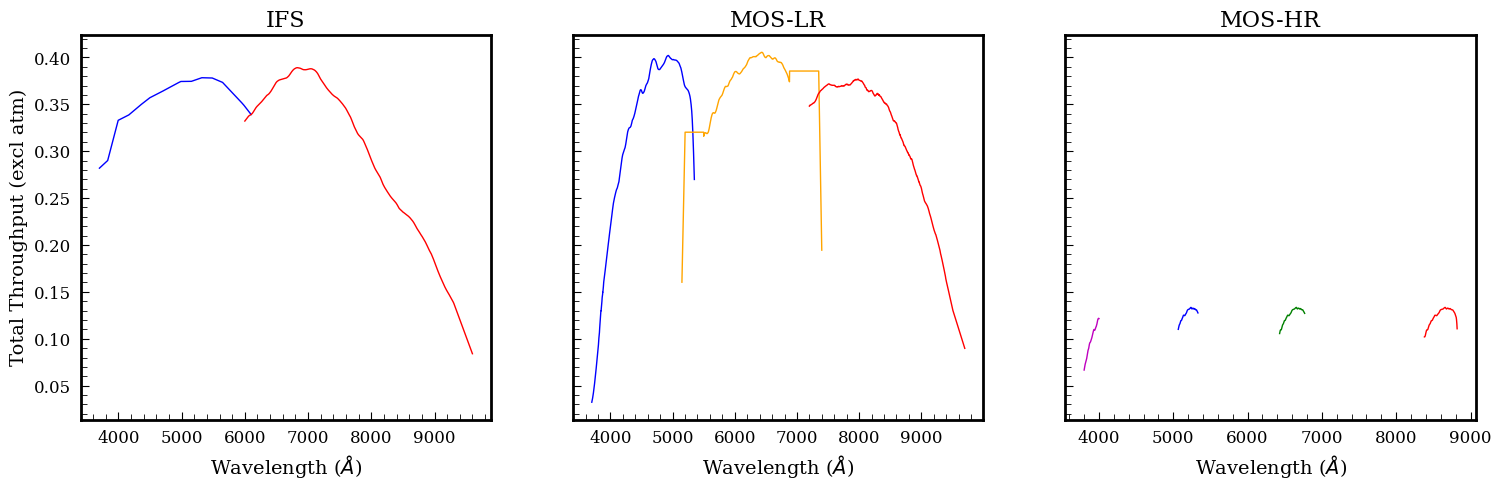

In [10]:
fig,ax = plt.subplots(1,3,figsize=(18,5), sharey=True)
ax[0].plot(obj_WST.ifs['blue']['instrans'].wave.coord(), obj_WST.ifs['blue']['instrans'].data, color='b')
ax[0].plot(obj_WST.ifs['red']['instrans'].wave.coord(), obj_WST.ifs['red']['instrans'].data, color='r')
ax[1].plot(obj_WST.moslr['blue']['instrans'].wave.coord(), obj_WST.moslr['blue']['instrans'].data, color='b')
ax[1].plot(obj_WST.moslr['orange']['instrans'].wave.coord(),obj_WST.moslr['orange']['instrans'].data, color='orange')
ax[1].plot(obj_WST.moslr['red']['instrans'].wave.coord(),obj_WST.moslr['red']['instrans'].data, color='r')

colo = ['m', 'b', 'g', 'r']
for i, chan in enumerate(obj_WST.moshr['channels']):
    ax[2].plot(obj_WST.moshr[chan]['instrans'].wave.coord(),obj_WST.moshr[chan]['instrans'].data, color = colo[i])
ax[0].set_xlabel(r'Wavelength ($\AA$)')
ax[1].set_xlabel(r'Wavelength ($\AA$)')
ax[2].set_xlabel(r'Wavelength ($\AA$)')
ax[0].set_ylabel('Total Throughput (excl atm)')
ax[0].set_title('IFS')
ax[1].set_title('MOS-LR')
ax[2].set_title('MOS-HR');

## OBSERVATION DATA STRUCTURE & SNR

The observations are stored as dictionaries, with keys that depend on the type of source being considered

The core object is a spectrum, defined also as a dictionary. We'll see all the type of sources, the easiest one is the **surface brightness** which means that is only defined by a spectrum, since it has not a spacial dependence (so in principle there should be no difference between _IFS_ and _MOS_ I guess)

## **surface brightness**:   
source which is entirely described by a spectrum, stored in `dspec`, this can be a:  
(1) `flatcont`  
(2) `line`  
(3) `template` (from the **Spextrum** package)  

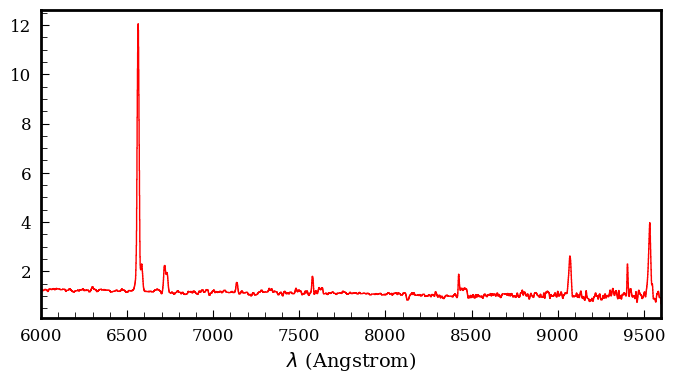

In [11]:
#try for a specific configuration, you can change this 
CONF = obj_WST.ifs['red']
c = 'r'
wave = 8500 #should be in Angstrom
dw_flat = 100
dw = 50

#Leave un-commented only the type of spectrum you want to see

#dspec = dict(type='flatcont', wave=[wave-dw_flat,wave+dw_flat])

#dspec = dict(type='line', lbda=wave, sigma=10, skew=0) #lbda is the central wavelenght

dspec = dict(type='template', name='kc96/starb1', redshift=0., wave_center=wave, wave_width=dw) #here wave and 
#wave_width are just the wavelenght and range to use for normalizing the spectrum and they have to be both
#of them inside the template range

#the method get_spec() 
spec = obj_WST.get_spec(CONF, dspec, oversamp=10, lsfconv=True) #the lsf is stored in the WST object describes 
#how a point source is spread out by the instrument's optics and detector

_, ax = plt.subplots(figsize=(8, 4))

spec.plot(ax=ax, color = c)

###############  
**(all)**  
We note that there is redundancy in the call of the wavelength step and others, since in `get_spec` this is compute both as `dlbda = ins['dlbda']` and `lstep = ins['instrans'].get_step()`, with the former using the original key stored for the configuration `ins`, while the second is using the built-in method of the `mpdaf.Spectrum object`  

**(2)**  
We note that there is no dependence on the `CONF` we choose, as in the case of `flatcont`, which means that even for instance selecting `CONF = obj_WST.ifs['red']` or every other configuration there won't be a check for the line to be inside the configuration wavelength range, it is plotted anyway  
###############

------
Once the spectrum is defined for this kind of source the other parameters are set through `set_obs(obs)` method where `obs` is once again a dictionary which can contain:  

- moon: string (`darksky`, `greysky` or `brightsky`)
- airmass: float, for now should match one of the pre-comuted configuration
- ndit and dit: number of exposure and time (in s) of every exp
- ima_type: string (`sb` for the surface brightness, we'll see after the case of point/extended) -> CHANGE OBJ TIPE
- ima_area: the size of the area to be considered for S/N computation. It is needed only for IFS, for the MOS it is defined by the fiber aperture (I guess in arcsec^2)  
###############  
- spec_type: string, can be `continuum` or `line` (not clear how it links with `flatcont`/`line`/`template` of the `dspec`, according to documentation when **templates** are passed with dspec this should be set to `continuum`    
###############  

Another parameter is always added:
- totexp: total exposures in hours (`obs['ndit']*obs['dit']/3600.0`)

Specifically for the `line` spectral type we got more parameters to set:
- spec_range_type: string (`fixed` or `adaptative`)  
  in the first case the `spec_range_hsize_spectels` is used for a window large as `2 * spec_range_hsize_spectels + 1`  
  in the second case the the window is instead computed based on the FWHM of the line through `spec_range_kfwhm`


The last important parameter is:  
###############  
flux: in erg s-1 cm-2 arcsec-2 (I guess in the case of `sb`)
Is there an error in the documentation? Should be in **erg s-1 cm-2 arcsec-2 AA-1**?
############### 

---
Let's set up an observation for this simple case of `sb` source we saw and the flux:

In [12]:
obs = dict(
    moon='darksky',
    airmass = 1.0,
    ndit = 2,
    dit = 1800,
    spec_type = 'cont',
    ima_type = 'sb',
    ima_area = 1.0
)

obj_WST.set_obs(obs)

flux = 5.e-19 #should be in erg/(cm^2 s A arcsec^2) in the case of surface brightness

Now, given the spectrum defined above (`spec`, in this case let's use the `template`/`flatcont` since we set `spec_type = 'cont'`) we can compute with the main method `snr_from_source` the SNR along with all the `res` products (as below), for our instrument+channel configuration `CONF`  
Since we are considering the `sb` case (but even for the point source `ps` as we'll see) no `ima` parameter is needed

In [13]:
res = obj_WST.snr_from_source(CONF, flux, ima=None, spec=spec)

[DEBUG] Source type sb & cont Flux 5.00e-19 S/N 3.1 FracFlux 1.000 Nspaxels 16 Nspectels 1


Let's see what the code is doing step by step:

- with `_checkobs` we copy the relevant keywords in `obs` that will be used
- if `obs['spec_type']` is `cont` the flux is converted in /spectel from the Angstroem/spectel values stored in the instrument configuration

So assumed now that the fluxes are actually flux densities we have: the flux density per unit spectel instead of AA, then:

- The flux density is converted in flux density per unit volume pixel, I assume converting arcsec^2 with `tflux *= ins['spaxel_size']**2` and now we have the flux density per unit detector area (pxl x pxl) instead of arcsec^2


- `chekcobs` for the `ima_area` parameter, then with

         nspaxels = int(obs['ima_area']/ins['spaxel_size']**2 + 0.5)
         
  we compute the number of spacial pixels needed to cover the `ima_area` requested (and the length of one side assumed square, we save also the `ima_area` in arcsec^2 for the IFS  
  
###############   
For the MOS this is done taking (again for excess) the number of spaxels needed to cover **2** times (why?) the area of the fiber size which is given in arcsec  

Another thing not completely clear to me is the fact that we compute frac_flux which is 1 since frac_ima and frac_spec are both 1 here, so I do not understand completely the reason behind this  
############### 


- The last point is in fact to compute the `snr_from_spec` which is done without frac_flux but with 
             
      spec_data = tflux * tspec
      
  So i suppose that that flux is the normalization of where you flux value is one, let's say that you have to normalize the continuum in the case of templates, for the flat is always one the value so its basically multiplication regardless the wavelength

##### So we see now how `snr_from_spec` works:

this below is what we are passing as a spec to snr_from_spec, you can print it below if needed

In [14]:
spec2 = spec*flux 

then we retrieve (given our configuration and moon condition) the sky emission/absorption and inst transm cutting if needed in the range of wavelength of spec2

In [15]:
#convenient function to get the mpdaf spectra of emission/absorption of the sky
###############
#Here we note that it looks at the airmass configurations stored in the static files, looking for the most similar one
#However this should be changed when talking directly with the ESO SkyCalc to generate one
###############
sky_emi,sky_abs = obj_WST.get_sky(CONF, obs['moon']) 

#convenient function on the mpdaf to cut on the length of the spectrum given (useful in this case for flat, since
#the templates are already spanning the range of the CONF)
ins_sky = sky_emi.subspec(lmin=spec2.wave.get_start(), lmax=spec2.wave.get_end())
ins_ins = CONF['instrans'].subspec(lmin=spec2.wave.get_start(), lmax=spec2.wave.get_end())
ins_atm = sky_abs.subspec(lmin=spec2.wave.get_start(), lmax=spec2.wave.get_end())

Other data such as:
- the spaxel area
- the wavelength step
- the telescope effective area

###############  
Not completely clear why we have both diameter and area of the telescope, it's not simply diameter:  

    np.pi*(obj_WST.tel['diameter']/2)**2 > obj_WST.tel['area']  
###############  

then we compute the signal to noise:

In [16]:
w = spec2.wave.coord() #Angstrom
tel_eff_area = obj_WST.tel['area']*CONF['obscuration']

C_cgs = constants.c.cgs.value
H_cgs = constants.h.cgs.value
C_kms = constants.c.to(u.km/u.s).value

#wave converted in cm then lambda/HC is 1/erg * area (cm^2) * atmosferic transmission
a = (w*1.e-8/(H_cgs*C_cgs)) * (tel_eff_area*1.e4) * (ins_atm.data)
#then also * instrument/telescope transmission
Kt =  ins_ins * a

so this is **1/erg cm2** at every wavelength, will be multiplied for the flux we stored before to get the number of photons that reaches the detector

In [17]:
nph_source = spec2.copy()
#taking into account the time of the observation we get: 
nph_source.data = obs['dit'] * obs['ndit'] * Kt.data * spec2.data

which should be the number of photons per unit 1 spaxel x 1 spaxel (while the array is of course per unit spectel)

###############  
My main doubt here is - and this could be also a silly one 😃, related to the MOS:  

For the CCD where the fiber send the light, let's say the X direction is the lambda and the Y is the is the spacial dispersion, is the X direction also a spacial direction? In this case the computation of every quantity in terms of unit spaxel size x unit spaxel size is correct, if there is only one spacial direction, the Y in this example, then every conversion from arcsec^2 to instrument should be done as spaxel size x 1 pixel...

If the correct answer is the first case: if we have to consider in more than one X pixel the PSF in the MOS, then we are mixing different wavelength right?
###############  

Anyway, we then compute the noises, starting from the sky emission and all the rest:

In [18]:
#here I could have also called as dl = CONF['dlbda']
dl = spec2.wave.get_step(unit='Angstrom')

#where the units of ins_sky (if you remember from tab.meta) are ph/s/m2/micron/arcsec2
nph_sky = ins_sky * ins_ins * obs['dit'] * obs['ndit'] * tel_eff_area * CONF['spaxel_size']**2 * (dl/1e4) 

#the other quantities
nb_voxels = 1 #since we are computing here the quantities for unit spectel and spaxels
ron_noise = np.sqrt(CONF['ron']**2*nb_voxels*obs['ndit'])
#because the dark current is given in hours we get
dark_noise = np.sqrt(CONF['dcurrent']*nb_voxels*obs['ndit']*obs['dit']/3600) 

###############  
I'm missing the conversion from photons to electron with **GAIN**, since the `ron` and `dark` are given in e- while we computed for the rest the photon numbers, related to this also the **QE**?  
###############  

In [19]:
sky_noise = nph_sky.copy()
sky_noise.data = np.sqrt(nph_sky.data)
source_noise = spec2.copy()
source_noise.data = np.sqrt(nph_source.data)
tot_noise = spec2.copy()
tot_noise.data = np.sqrt(ron_noise**2 + dark_noise**2 + sky_noise.data**2 + source_noise.data**2)
snr = spec2.copy()

#final computation of the SNR per unit spaxels (as a function of spectel)
snr.data = nph_source.data / tot_noise.data

You can plot it below

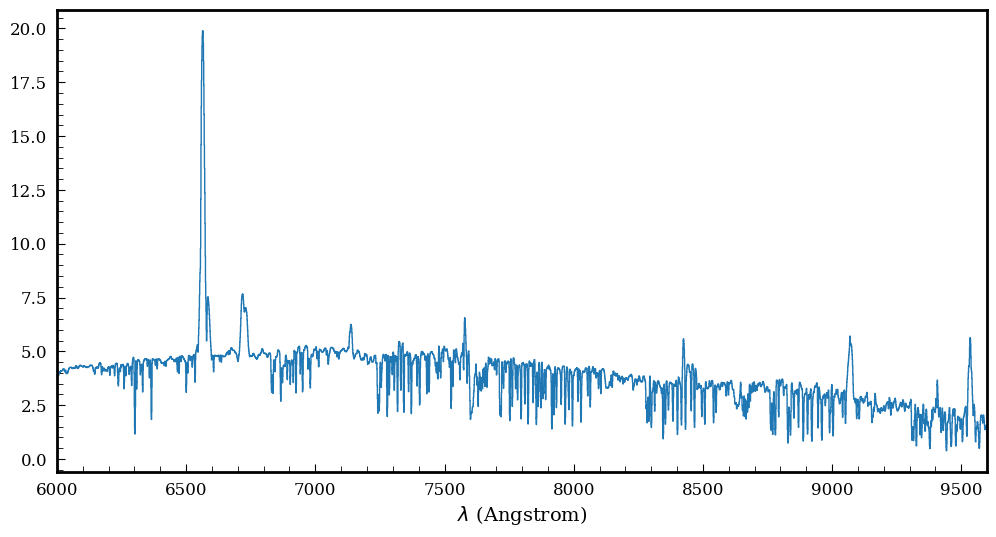

In [20]:
snr.plot()

The full results are returned as dictionaries, including:
- a subdictionary of all noises
- number of photons from source and sky
- SNR (in this case per unit voxel)
- all the inputs used (obs, CONF, ecc...)

Lastly, the SNR is computed additionaly also per unit area passed via `obs['ima_area']`, which is used for the IFS, while for the MOS this is by default set from the fiber `aperture` parameter from the used `CONF`.

It is then stored along with all other quantities (number of photons/noises/ecc...) in `res['spec']`

And you can see from the plot below how there is a slight difference in our example in the SNR, since this is integrated in an area of 1"x1" (`obs['ima_area']`) instead of 1 spaxel x 1 spaxel (0.25" x 0.25" in our `CONF`)

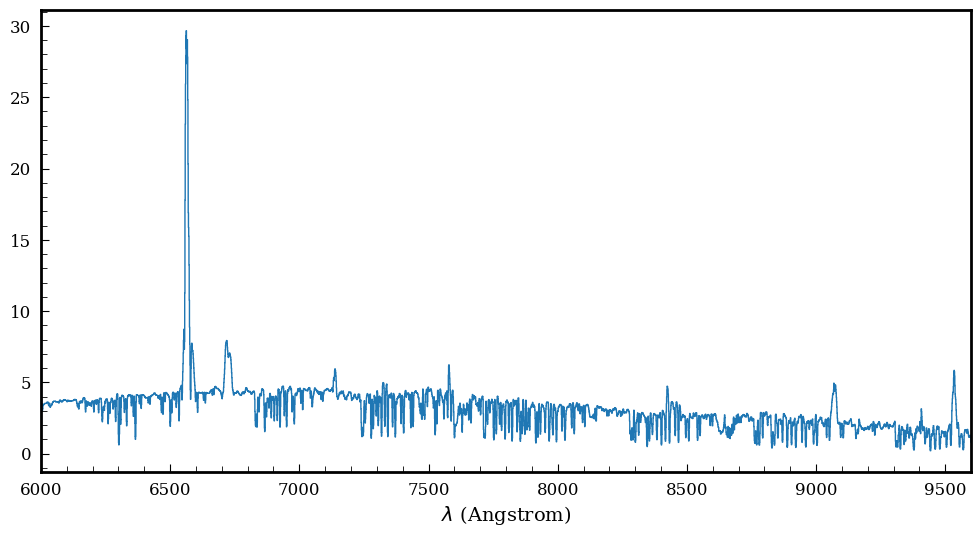

In [21]:
res['spec']['snr'].plot()

other quantities are stored in the results as well, such as the detector noise fraction on the total noise:
            
    detnoise = nspaxels*(resc['noise']['ron']**2+resc['noise']['dark']**2) / tot_noise.data.data**2
    
For the full set of parameters available look at the documentation: https://pyetc-wst.readthedocs.io/en/latest/tutorial.html

---

Let's give a quick look now to the `emission line` spectra case always in the `sb` spacial case (I copied below the initial cell with the `line` spectral dictionar enabled):

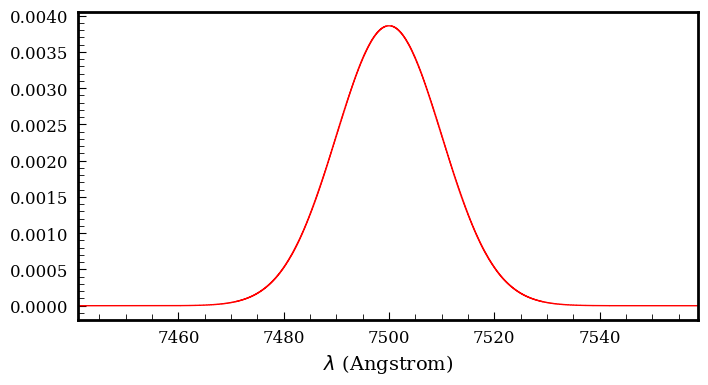

In [22]:
#try for a specific configuration, you can change this 
CONF = obj_WST.ifs['red']
c = 'r'
wave = 7500 #should be in Angstrom
dw = 50

dspec = dict(type='line', lbda=wave, sigma=10, skew=0) #lbda is the central wavelenght

#the method get_spec() 
spec = obj_WST.get_spec(CONF, dspec, oversamp=10, lsfconv=True)

_, ax = plt.subplots(figsize=(8, 4))

spec.plot(ax=ax, color = c)

Beware that by definition here is the whole area of the line that is normalized to 1, not the mean in a wavelength range or the continuum of the flat as before, you can see it below:

In [23]:
print(f'{np.trapz(spec.data):.2f}')

1.00


Now we set up the observation as before, we saw already that there are few more parameters to handle:

In [24]:
#you can change fixed or adaptative to define the number of spectel manually or a K times the FWHM
obs = dict(
    moon='darksky',
    airmass = 1.0,
    ndit = 2,
    dit = 1800,
    spec_type = 'line',
    ima_type = 'sb',
    ima_area = 1.0,
    spec_range_type = 'adaptative'
)



if obs['spec_range_type'] == 'fixed':
    obs['spec_range_hsize_spectels'] = 4
elif obs['spec_range_type'] == 'adaptative':
    obs['spec_range_kfwhm'] = 2
    
obj_WST.set_obs(obs)

flux = 1.e-18 #should be in erg/(cm^2 s arcsec^2) in the case of surface brightness, 
#this should be already integrated in the line range I guess, so without the Angstrom

###############  
Beware that the line in terms of `get_spec` do not have a check for it being inside the range of the chosen `CONF`, which means simply that errors will be produced if you try to do all the computations without checking before, we should add something at `get_spec` level.
    
For istance just check by putting lets say a line at 3500AA and the `ifs['red']` configuration, you'll see that two cells above the `get_spec` method will return the line but you won't be able to use it below, getting error...  
############### 

In [25]:
res = obj_WST.snr_from_source(CONF, flux, ima=None, spec=spec)

[DEBUG] Source type sb & line Flux 1.00e-18 S/N 0.9 FracFlux 0.984 Nspaxels 16 Nspectels 50


Let's see what is done differently with respect to the `flatcont` and `template` cases.
Here we'll have to cut the spectrum around the line adaptatively or in a fixed way, in both cases a `truncate_spec` method is used, the spectrum is cut around the line, returning:

        tspec = rspec.subspec(lmin=nl1, lmax=nl2)
        waves = tspec.wave.coord()
        nspectels = tspec.shape[0]
        size = tspec.get_end() - tspec.get_start()
        frac_flux = tspec.data.sum()
        return tspec,waves,nspectels,size,frac_flux
        
Where `tspec` is the spectrum (dimensionless) in the range of wave considered, `waves` are the wavelengths, `size` is the wavelengths range, and `frac_flux` is the fraction of the total flux of the line considered in the range

In [26]:
if obs['spec_range_type'] == 'fixed':
    X = obj_WST.truncate_spec_fixed(CONF,spec, obs['spec_range_hsize_spectels'])
elif obs['spec_range_type'] == 'adaptative':
    X = obj_WST.truncate_spec_adaptative(CONF,spec, obs['spec_range_kfwhm'])


###############  
Remember that it is the sum that remains the same here—when we perform `truncate_spec`, which includes the resampling step, the total flux is preserved. Therefore, the flux in each bin already represents the flux over the wavelength range covered by the bin, not at a specific wavelength.   
But why like this?  
###############  

the fraction of the flux is: 98.40% of the total line flux


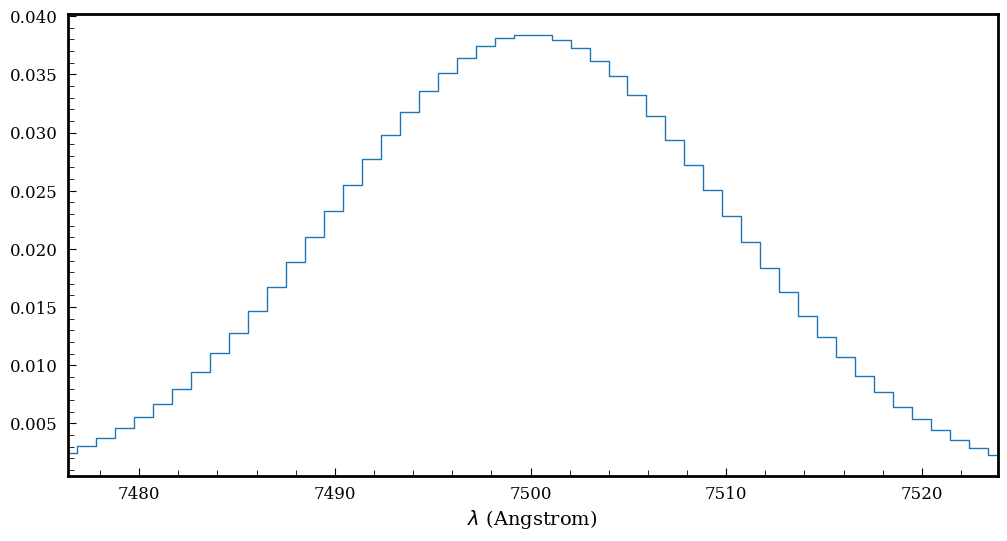

In [27]:
#Here you can see the tspec and the frac_flux
print('the fraction of the flux is: {:.2f}% of the total line flux'.format(X[4]*100))
X[0].plot()
#you will se with this that the value of the spec is dependent on the wave range if you plot it
#spec.plot()

The `res` dictionary now contains all the quantities we saw before since it is again computed from `snr_from_spec`, however we are not really interested in the SNR per unit wavelength here, rather in the SNR on the total flux of the line.

For this reason another keyword is added to the results: `aper`, which contains the results integrated over the line, in general we know then that there are:

- `res['cube']` with all the results per unit spaxels and spectel
- `res['spec']` integrated on an area, so only per unit spectel
- `res['aper']` integrated on both

You can see below in this case `res['aper']['snr']` is a number

In [28]:
obj_WST.print_aper(res, 'aperture values')

item,aperture values
bytes20,bytes20
snr,0.912
size,1
area,1
frac_flux,0.984
frac_ima,1
...,...
ron,120
dark,48.99
sky_noise,386.5


In the results we have also the truncated spectrum:

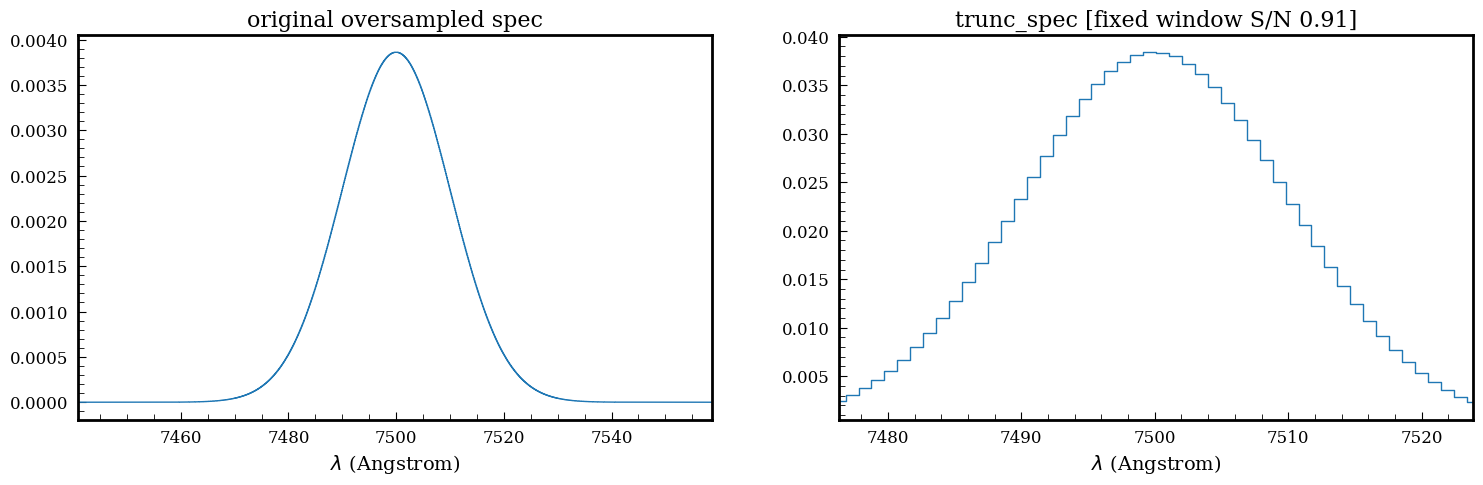

In [29]:
fig,ax = plt.subplots(1,2,figsize=(18,5))
spec.plot(ax=ax[0], title='original oversampled spec')
res['cube']['trunc_spec'].plot(ax=ax[1], title=f"trunc_spec [fixed window S/N {res['aper']['snr']:.2f}]")

___
There is a function to automatically compute the optimum spectral range for the adaptative window: 

In [30]:
obj_WST.optimum_spectral_range(CONF,flux,None,spec)

[DEBUG] Optimizing kwhm in [0.04121339297491103, 4.488138494967812]
[DEBUG] Optimum spectral range nit=7 kfwhm=1.10 S/N=1.2 Size=26.2 Flux=1.00e-18 Frac=0.82


1.097027873175985

Inside we have:
    
    res = minimize_scalar(_fun_range, args=(self, ins, flux, ima, spec),
                              bounds=bracket, options=dict(xatol=0.01), method='bounded')
                              
which uses `_fun_range(kfwhm, obj, ins, flux, ima, spec)` with `args` all the other parameters which are not `kfwhm` are passed

###############  
I do not really get why we do: 

    obs['ima_type'] = 'resolved'  
    
since this is not used and is set back to `ps`, but maybe is something specifically for the `ps` case we'll see later  
############### 

___
### FLUX to achieve a fixed SNR

With `flux_from_source`: for the `line` that is fairly easy, `krange` is not used and the results are reported for the entire range of wavelength of `spec`,

For the `cont` there are few more parameters to set, we want the `snrcomp` dictionary with:

        snrcomp=dict(method='mean', waves=[7000,8000])

A method (`mean` or `sum`) and the wavelength range `waves` (for the mean) or `wave` and `npix` (for the sum) to compute the SNR

###############   
This part in `fun` could have been done more easily adding the mean of the SNR in the `res['spec']` dictionary, and instead if this is correct there should be the same for the median, is it not done on the entire range of spec in the other case? Should test it below
            
            elif krange[2] == 'sum':
                snr = np.sum(res['spec']['nph_source'].data[krange[0]:krange[1]]) \
                    / np.sqrt(np.sum(res['spec']['noise']['tot'].data[krange[0]:krange[1]]**2))
                    
My interpratation is that for `mean` the snr passed is intended as the mean in the entire range of `spec` and then the SNR is returned in the range specified by `waves`

In the case of `sum` we have a similar thing but instead the SNR is computed in the right range passed and the root finding algoritm is done there, but the computation does not seem to be there. 

#### We should change a couple of things here:
keeping only the mean as used and computing the quantities only on the interval of wavelength passed  
###############


In [31]:
#You can play here and see how this is computed
wave,dw = 6000,500
dspec = dict(type='template', name='kc96/starb1',
             wave_center=wave, wave_width=dw)
spec = obj_WST.get_spec(CONF, dspec)
obs = dict(
    moon = 'darksky',
    airmass = 1.0,
    ndit = 2,
    dit = 1800,
    spec_type = 'cont',
    ima_type = 'sb',
    ima_area = 1.0
)
obj_WST.set_obs(obs)
snr = 4
res = obj_WST.flux_from_source(CONF, snr, None, spec, snrcomp=dict(method='mean', waves=[6000,9600]))

      converged: True
           flag: converged
 function_calls: 7
     iterations: 6
           root: 82.26114051469682
         method: brenth
[DEBUG] Source type sb & cont Flux 8.23e-19 S/N 4.0 FracFlux 1.000 Nspaxels 16 Nspectels 1
[DEBUG] SN 4.02 Flux 8.23e-19 Iter 6 Fcall 7 converged True


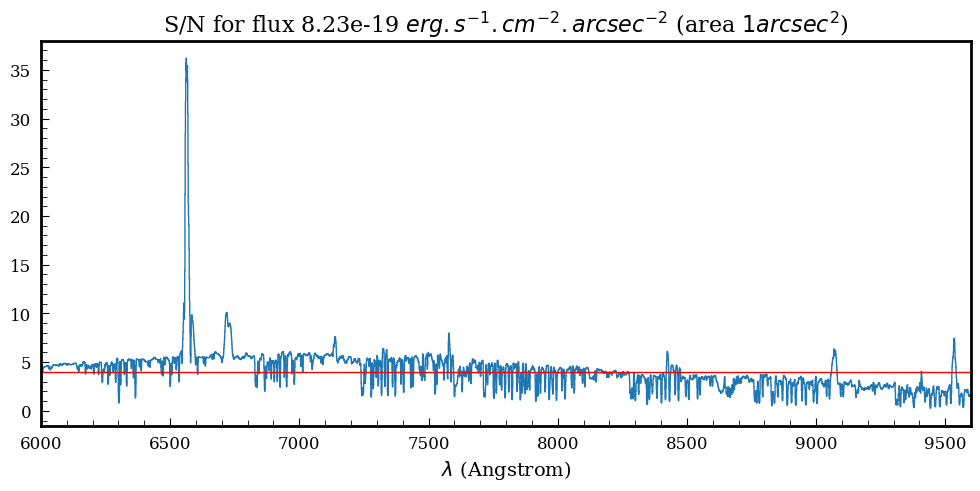

In [32]:
fig,ax = plt.subplots(1,1,figsize=(12,5))
res['spec']['snr'].plot(ax=ax)
ax.set_title(f"S/N for flux {res['spec']['flux']:.2e} "+r"$erg.s^{-1}.cm^{-2}.arcsec^{-2}$ (area $1 arcsec^2$)")
ax.axhline(snr, color='r');

## **point source**:   

The first thing is the image quality, which is the FWHM (in arcsec) expected for point sources with a certain seeing (for default at 5000 AA) and a specified airmass, the other parameters are taken from the WST dictionary as well as from paranal site values

###############  
Beware that the image quality of the instrument+telescope is given togheter
#### Should we change it? 

### Yes this should be changed
###############

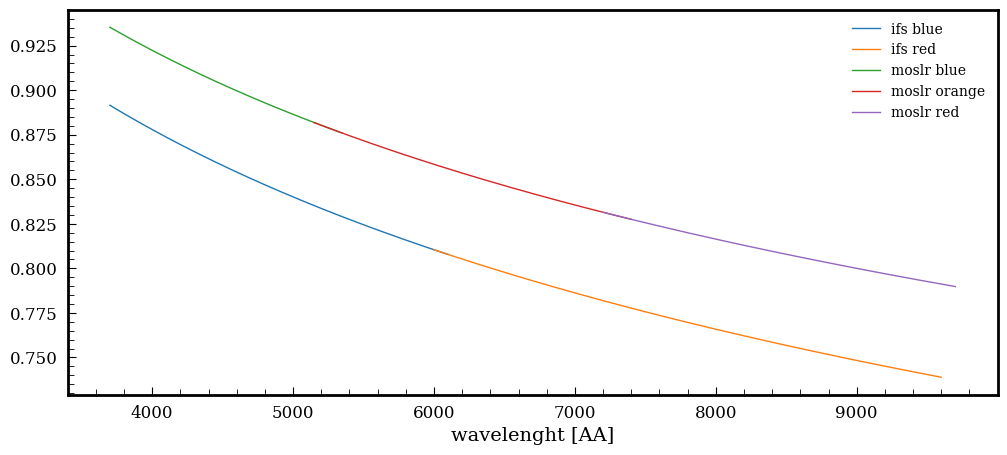

In [33]:
from pyetc.etc import get_seeing_fwhm

fig,ax = plt.subplots(1,1,figsize=(12,5))

#change this to see how it changes the IQ
seeing = 1
airmass = 1
for ins in [obj_WST.ifs, obj_WST.moslr]:
    for chan in ins['channels']:
        inst = ins[chan]
        wave = inst['wave'].coord()
        fwhm = get_seeing_fwhm(seeing, airmass, wave, obj_WST.tel['diameter'], inst['iq_fwhm'])
        ax.plot(wave, fwhm, label=f"{inst['name']} {chan}")
ax.legend()
ax.set_xlabel('wavelenght [AA]');

Let's see now how it works the SNR computation, starting from the continuum spectral case, let's set the observation:

In [34]:
from mpdaf.obj import mag2flux

CONF = obj_WST.moslr['blue']
wave,dw  = 5500,500
dspec = dict(type='template', name='ref/sun',
             wave_center=wave, wave_width=dw)
spec = obj_WST.get_spec(CONF, dspec)
mag = 23
flux = mag2flux(mag, wave)
obs = dict(
    moon = 'brightsky',
    seeing = 1.0,
    airmass = 1.0,
    ndit = 2,
    dit = 1800,
    spec_type = 'cont',
    ima_type = 'ps'
)
obj_WST.set_obs(obs)

res = obj_WST.snr_from_source(CONF, flux, None, spec)

[DEBUG] Computing frac and nspaxels for 20 wavelengths (lbin 20)
[DEBUG] Performing interpolation
[DEBUG] At 3700.0 A  FWHM: 0.94 Flux fraction: 0.45 Aperture: 1.0 Nspaxels: 21
[DEBUG] At 5349.8 A  FWHM: 0.88 Flux fraction: 0.48 Aperture: 1.0 Nspaxels: 21
[DEBUG] Source type ps & cont Flux 2.27e-18 S/N 1.5 FracFlux 0.462 Nspaxels 21 Nspectels 1


We get:

    lbin = 20 if spec.shape[0]>100 else 1   
The spectrum is divided in several parts, step = 1 unless the spec has more than 100 entries, in that case 20 (i guess AA), then we compute `get_psf_frac_ima`

Inside `get_psf_frac_ima` we use the `get_image_quality` which uses the `get_seeing_fwhm` that we saw above in the CONF we have choosen, look at it below:

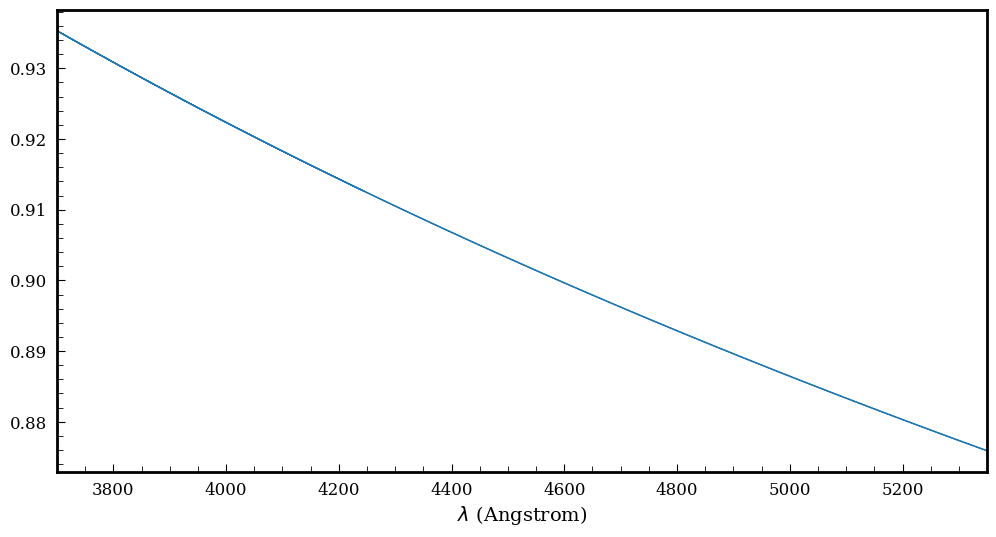

In [35]:
#you can see it's the same as the other one 
IQ = obj_WST.get_image_quality(CONF,spec)

IQ.plot()

FOR THE IFS:  
After it computes the MOFFAT profile for the two wavelength at the edges it compute the `optimal_circular_aperture` to maximaze the SNR given that specific profile, which has a FWHM fixed, this is done considering the range of the spectrum which by default is the 80% central part, and the maximization is done considering the mean SNR in that range. 

This can be done also not with the `optimal_circular_aperture` which is used to interpolate the case of the `adaptative_circular_aperture`, but instead with the `square_aperture` where you also pass in the `obs` dictionary `obs['ima_aperture_hsize_spaxels']`

In every case useful interpolations are done, and after all if `lbin>1` we interpolate after computing the quantities for the wavelength every 20 AA it seems

FOR THE MOS:  
The computation is done with the `fixed_circular_aperture(ins, ima, 0.5*ins['aperture'])` where the diameter of the fiber is used
___
You can test here below the `get_psf_frac_ima` method

[DEBUG] Computing frac and nspaxels for 50 wavelengths (lbin 50)
[DEBUG] Performing interpolation
[DEBUG] At 3700.0 A  FWHM: 0.94 Flux fraction: 0.45 Aperture: 1.0 Nspaxels: 21
[DEBUG] At 5349.8 A  FWHM: 0.88 Flux fraction: 0.48 Aperture: 1.0 Nspaxels: 21


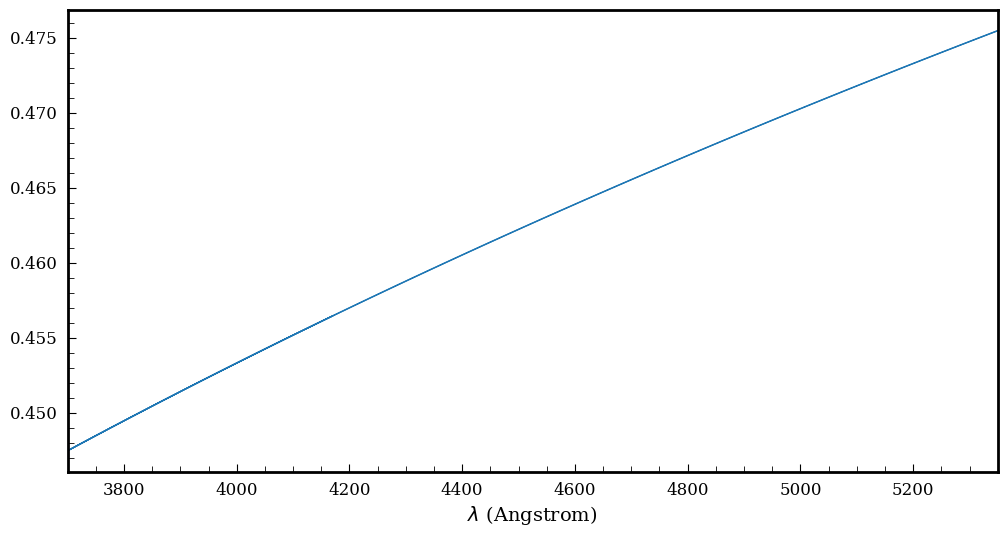

In [36]:
PSF_wave = obj_WST.get_psf_frac_ima(CONF,flux,spec, lbin=50)

PSF_wave[0].plot()

If you also want to see the images of the PSF play with the cell below:

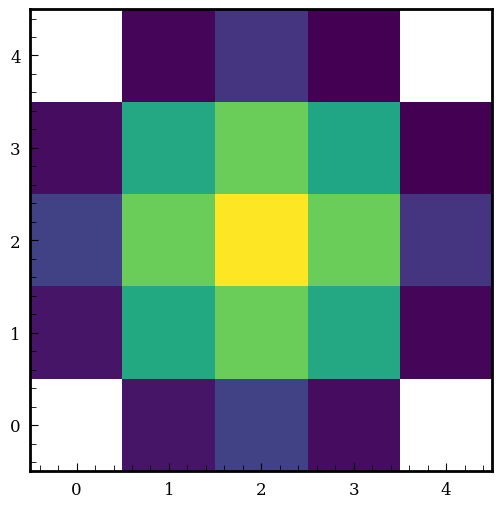

In [37]:
im_PSF = obj_WST.get_image_psf(CONF,5500)
im = obj_WST.fixed_circular_aperture(CONF, im_PSF, 0.5*CONF['aperture'])

im[0].plot()

By default cells with a flux below 1/16 of the peak are cutted
___
We can do the same computation for the emission line mixing what we saw above for the `line` and here for the `ps` case

In [38]:
mos = obj_WST.moslr['blue']
ifs = obj_WST.ifs['blue']
wave = 4900
dspec = dict(type='line', lbda=wave, sigma=4.0, skew=7.0)
flux= 5.e-18
obs = dict(
    moon = 'darksky',
    seeing = 0.7,
    airmass = 1.0,
    ndit = 2,
    dit = 1800,
    spec_type = 'line',
    spec_range_type = 'adaptative',
    ima_type = 'ps',
    ima_aperture_type = 'circular_adaptative',
    spec_range_kfwhm = 2,
       
)

#you can also don't use it as long as the other one is used to compute the kfwhm_spec or kfwhm_ima
#spec_range_kfwhm = 2,
#ima_kfwhm = 2
obj_WST.set_obs(obs)
spec = obj_WST.get_spec(ifs, dspec)

kfwhm_ima = obj_WST.optimum_circular_aperture(ifs, flux, None, spec)
kfwhm_spec = obj_WST.optimum_spectral_range(ifs, flux, None, spec)

res1 = obj_WST.snr_from_source(ifs, flux, None, spec)
spec = obj_WST.get_spec(mos, dspec)
res2 = obj_WST.snr_from_source(mos, flux, None, spec)

[DEBUG] Optimum circular aperture nit=4 kfwhm=8.38 S/N=6.4 Aper=1.4 Flux=5.00e-18 Frac=0.96
[DEBUG] Optimizing kwhm in [0.21559252230162143, 3.919472055443478]


/Users/matteoferro/Library/Python/3.9/lib/python/site-packages/mpdaf/obj/image.py:1291: MpdafWarning: fwhm method is deprecated. Use fwhm_gauss method instead.
  warnings.warn(
/Users/matteoferro/Library/Python/3.9/lib/python/site-packages/mpdaf/obj/image.py:1291: MpdafWarning: fwhm method is deprecated. Use fwhm_gauss method instead.
  warnings.warn(
/Users/matteoferro/Library/Python/3.9/lib/python/site-packages/mpdaf/obj/image.py:1291: MpdafWarning: fwhm method is deprecated. Use fwhm_gauss method instead.
  warnings.warn(
/Users/matteoferro/Library/Python/3.9/lib/python/site-packages/mpdaf/obj/image.py:1291: MpdafWarning: fwhm method is deprecated. Use fwhm_gauss method instead.
  warnings.warn(
/Users/matteoferro/Library/Python/3.9/lib/python/site-packages/mpdaf/obj/image.py:1291: MpdafWarning: fwhm method is deprecated. Use fwhm_gauss method instead.
  warnings.warn(
/Users/matteoferro/Library/Python/3.9/lib/python/site-packages/mpdaf/obj/image.py:1291: MpdafWarning: fwhm method i

[DEBUG] Optimum spectral range nit=8 kfwhm=1.06 S/N=7.0 Size=5.1 Flux=5.00e-18 Frac=0.77
[DEBUG] Computing PSF at 4901.3 fwhm 0.59 beta 2.5
[DEBUG] Adaptive circular aperture diameter 1.43 frac_flux 0.96
[DEBUG] Source type resolved & line Flux 5.00e-18 S/N 7.0 FracFlux 0.737 Nspaxels 21 Nspectels 9
[DEBUG] Computing PSF at 4901.3 fwhm 0.66 beta 2.5
[DEBUG] Source type resolved & line Flux 5.00e-18 S/N 5.2 FracFlux 0.517 Nspaxels 19 Nspectels 15


/Users/matteoferro/Library/Python/3.9/lib/python/site-packages/mpdaf/obj/image.py:1291: MpdafWarning: fwhm method is deprecated. Use fwhm_gauss method instead.
  warnings.warn(
/Users/matteoferro/Library/Python/3.9/lib/python/site-packages/mpdaf/obj/image.py:1291: MpdafWarning: fwhm method is deprecated. Use fwhm_gauss method instead.
  warnings.warn(
/Users/matteoferro/Library/Python/3.9/lib/python/site-packages/mpdaf/obj/image.py:1291: MpdafWarning: fwhm method is deprecated. Use fwhm_gauss method instead.
  warnings.warn(
/Users/matteoferro/Library/Python/3.9/lib/python/site-packages/mpdaf/obj/image.py:1291: MpdafWarning: fwhm method is deprecated. Use fwhm_gauss method instead.
  warnings.warn(
/Users/matteoferro/Library/Python/3.9/lib/python/site-packages/mpdaf/obj/image.py:1291: MpdafWarning: fwhm method is deprecated. Use fwhm_gauss method instead.
  warnings.warn(
/Users/matteoferro/Library/Python/3.9/lib/python/site-packages/mpdaf/obj/image.py:1291: MpdafWarning: fwhm method i

###############  
I don't understand why you have to specify before the `spec_range_kfhwm` and `ima_kfwhm` but could be something related to the `line`, since to compute one it seems you need the other, It seems it's not relevant, maybe it is just needed at the beginning to make guesses to find root/minimum, check properly in the code  
###############  

In [39]:
obj_WST.print_aper([res1,res2],['ifs','mos'])

item,ifs,mos
bytes20,bytes20,bytes20
snr,6.974,5.201
size,1.427,1
area,1.599,0.7854
frac_flux,0.7367,0.5172
frac_ima,0.9556,0.6406
...,...,...
ron,58.33,71.62
dark,23.81,29.24
sky_noise,100.8,109.1


And again we could retrieve the `flux` needed to get a specific `snr`:

In [40]:
mos = obj_WST.moslr['red']
ifs = obj_WST.ifs['red']
moon = 'darksky'
wave = 8000
dspec = dict(type='line', lbda=wave, sigma=4.0, skew=7.0)
#flux not relevant
#flux= 10000000 
obs = dict(
    moon = 'darksky',
    seeing = 0.7,
    airmass = 1.0,
    ndit = 2,
    dit = 1800,
    spec_type = 'line',
    spec_range_type = 'adaptative',
    spec_range_kfwhm = 1.2,
    ima_type = 'ps',
    ima_aperture_type = 'circular_adaptative',
    ima_kfwhm = 5
)
obj_WST.set_obs(obs)
snr = 3
spec = obj_WST.get_spec(ifs, dspec)
res1 = obj_WST.flux_from_source(ifs, snr, None, spec)
spec = obj_WST.get_spec(mos, dspec)
res2 = obj_WST.flux_from_source(mos, snr, None, spec)

/Users/matteoferro/Library/Python/3.9/lib/python/site-packages/mpdaf/obj/image.py:1291: MpdafWarning: fwhm method is deprecated. Use fwhm_gauss method instead.
  warnings.warn(
/Users/matteoferro/Library/Python/3.9/lib/python/site-packages/mpdaf/obj/image.py:1291: MpdafWarning: fwhm method is deprecated. Use fwhm_gauss method instead.
  warnings.warn(
/Users/matteoferro/Library/Python/3.9/lib/python/site-packages/mpdaf/obj/image.py:1291: MpdafWarning: fwhm method is deprecated. Use fwhm_gauss method instead.
  warnings.warn(


      converged: True
           flag: converged
 function_calls: 7
     iterations: 6
           root: 182.566780319654
         method: brenth
[DEBUG] Computing PSF at 8001.6 fwhm 0.54 beta 2.5
[DEBUG] Adaptive circular aperture diameter 0.83 frac_flux 0.67
[DEBUG] Source type resolved & line Flux 1.83e-18 S/N 3.0 FracFlux 0.578 Nspaxels 9 Nspectels 8
[DEBUG] SN 3.00 Flux 1.83e-18 Iter 6 Fcall 7 converged True


/Users/matteoferro/Library/Python/3.9/lib/python/site-packages/mpdaf/obj/image.py:1291: MpdafWarning: fwhm method is deprecated. Use fwhm_gauss method instead.
  warnings.warn(
/Users/matteoferro/Library/Python/3.9/lib/python/site-packages/mpdaf/obj/image.py:1291: MpdafWarning: fwhm method is deprecated. Use fwhm_gauss method instead.
  warnings.warn(
/Users/matteoferro/Library/Python/3.9/lib/python/site-packages/mpdaf/obj/image.py:1291: MpdafWarning: fwhm method is deprecated. Use fwhm_gauss method instead.
  warnings.warn(
/Users/matteoferro/Library/Python/3.9/lib/python/site-packages/mpdaf/obj/image.py:1291: MpdafWarning: fwhm method is deprecated. Use fwhm_gauss method instead.
  warnings.warn(
/Users/matteoferro/Library/Python/3.9/lib/python/site-packages/mpdaf/obj/image.py:1291: MpdafWarning: fwhm method is deprecated. Use fwhm_gauss method instead.
  warnings.warn(


      converged: True
           flag: converged
 function_calls: 7
     iterations: 6
           root: 180.43298296054311
         method: brenth
[DEBUG] Computing PSF at 8001.5 fwhm 0.61 beta 2.5
[DEBUG] Source type resolved & line Flux 1.80e-18 S/N 3.0 FracFlux 0.627 Nspaxels 17 Nspectels 11
[DEBUG] SN 3.00 Flux 1.80e-18 Iter 6 Fcall 7 converged True


In [41]:
obj_WST.print_aper([res1,res2],['ifs','mos'])

item,ifs,mos
bytes20,bytes20,bytes20
snr,3,3
size,0.8269,1
area,0.537,0.7854
frac_flux,0.5783,0.627
frac_ima,0.6692,0.7606
...,...,...
dark,14.7,23.69
sky_noise,108.4,164.3
source_noise,18.71,23.07


## **resolved source**:   

We define an image with `get_ima`

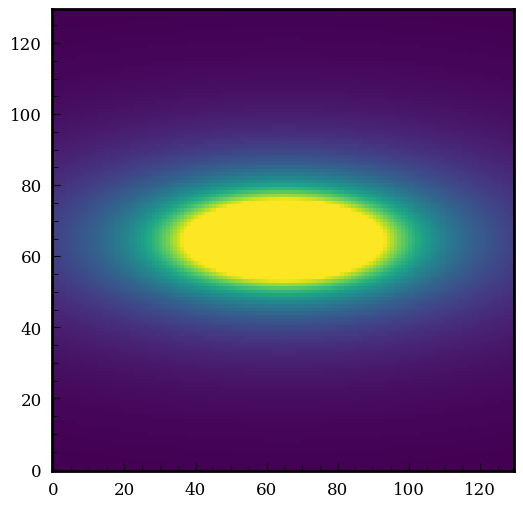

In [42]:
ifs = obj_WST.ifs['red']
dima = dict(type='sersic', reff=1.0, n=2.0, ell=0.6)
ima = obj_WST.get_ima(ifs, dima)
ima.plot(zscale=True)

The rest is similar to the point source case, where the image is generated by the `get_image_psf`, here we don't have yet the PSF convolution, so you have to give already the observed image expected for an extended source

One parameter more that we have is `res[‘cube’][‘trunc_ima’]` where the `ima` used for the computation is stored.

Anyway the number of pixels is constant for the entire wavelength range it seems, and all the calculations above can be performed:

In [43]:
ifs = obj_WST.ifs['red']
wave = 8000
dspec = dict(type='flatcont', wave=[wave-10,wave+10])
spec = obj_WST.get_spec(ifs, dspec)
dima = dict(type='moffat', fwhm=1.0, beta=2.5)
ima = obj_WST.get_ima(ifs, dima)
mag = 23
flux = mag2flux(mag, wave)
obs = dict(
    moon = 'greysky',
    airmass = 1.0,
    ndit = 2,
    dit = 1800,
    spec_type = 'cont',
    ima_type = 'resolved',
    ima_aperture_type = 'circular_adaptative',
    ima_kfwhm = 5,
)

obj_WST.set_obs(obs)
res1 = obj_WST.snr_from_source(ifs, flux, ima, spec)
obs = dict(
    moon = 'greysky',
    airmass = 1.0,
    ndit = 2,
    dit = 1800,
    spec_type = 'cont',
    ima_type = 'resolved',
    ima_aperture_type = 'square_fixed',
    ima_aperture_hsize_spaxels = 2,
)
obj_WST.set_obs(obs)
res2 = obj_WST.snr_from_source(ifs, flux, ima, spec)

mos = obj_WST.moslr['red']
spec = obj_WST.get_spec(mos, dspec)
ima = obj_WST.get_ima(mos, dima)
obs = dict(
    moon = 'greysky',
    airmass = 1.0,
    ndit = 2,
    dit = 1800,
    spec_type = 'cont',
    ima_type = 'resolved',
)
obj_WST.set_obs(obs)
res3 = obj_WST.snr_from_source(mos, flux, ima, spec)

[DEBUG] Adaptive circular aperture diameter 1.18 frac_flux 0.46
[DEBUG] Source type resolved & cont Flux 1.07e-18 S/N 1.8 FracFlux 0.461 Nspaxels 21 Nspectels 1
[DEBUG] Source type resolved & cont Flux 1.07e-18 S/N 2.0 FracFlux 0.565 Nspaxels 25 Nspectels 1
[DEBUG] Source type resolved & cont Flux 1.07e-18 S/N 1.4 FracFlux 0.371 Nspaxels 21 Nspectels 1


/Users/matteoferro/Library/Python/3.9/lib/python/site-packages/mpdaf/obj/image.py:1291: MpdafWarning: fwhm method is deprecated. Use fwhm_gauss method instead.
  warnings.warn(


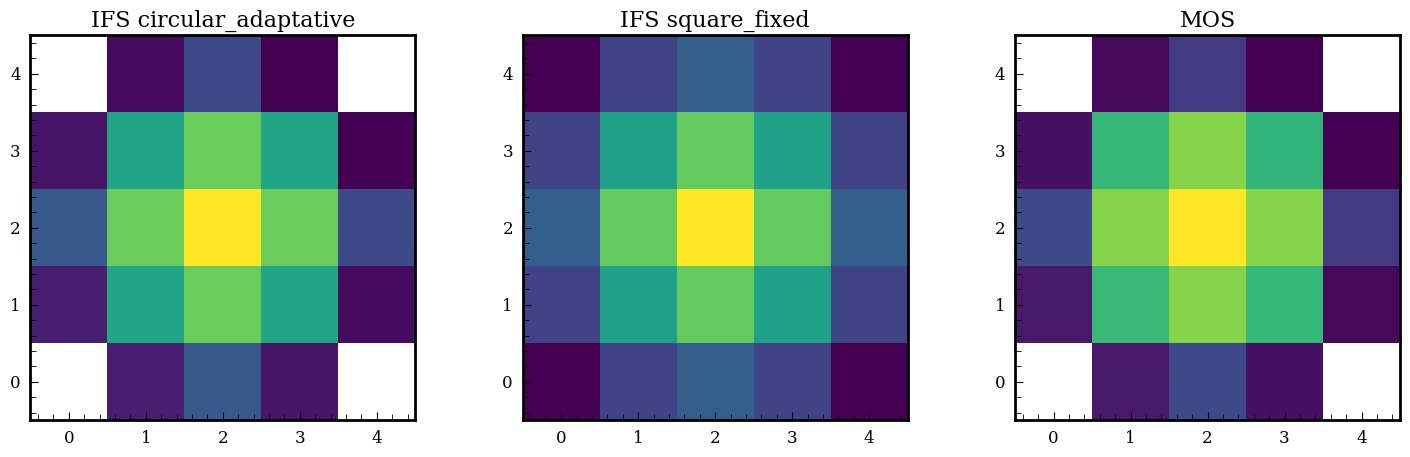

In [44]:
fig,ax = plt.subplots(1,3,figsize=(18,5))
res1['cube']['trunc_ima'].plot(ax=ax[0], title='IFS circular_adaptative')
res2['cube']['trunc_ima'].plot(ax=ax[1], title='IFS square_fixed')
res3['cube']['trunc_ima'].plot(ax=ax[2], title='MOS')

To conlcude is possible also in this case for the IFS to compute the `optimum_circular_aperture` to use in order to maximaze the SNR

In [45]:
ifs = obj_WST.ifs['red']
wave = 7000
dspec = dict(type='flatcont', wave=[wave-10,wave+10])
spec = obj_WST.get_spec(ifs, dspec)
dima = dict(type='moffat', fwhm=1.0, beta=2.5)
ima = obj_WST.get_ima(ifs, dima)
mag = 23
flux = mag2flux(mag, wave)
obs = dict(
    moon = 'greysky',
    airmass = 1.0,
    ndit = 2,
    dit = 1800,
    spec_type = 'cont',
    ima_type = 'resolved',
    ima_aperture_type = 'circular_adaptative',
    ima_kfwhm = 5,
)
obj_WST.set_obs(obs)
kfwhm = obj_WST.optimum_circular_aperture(ifs, flux, ima, spec, lrange=[wave-5,wave+5])
res4 = obj_WST.snr_from_source(ifs, flux, ima, spec)

[DEBUG] Optimum circular aperture nit=7 kfwhm=7.05 S/N=3.1 Aper=1.7 Flux=1.40e-18 Frac=0.66
[DEBUG] Adaptive circular aperture diameter 1.66 frac_flux 0.66


/Users/matteoferro/Library/Python/3.9/lib/python/site-packages/mpdaf/obj/image.py:1291: MpdafWarning: fwhm method is deprecated. Use fwhm_gauss method instead.
  warnings.warn(
/Users/matteoferro/Library/Python/3.9/lib/python/site-packages/mpdaf/obj/image.py:1291: MpdafWarning: fwhm method is deprecated. Use fwhm_gauss method instead.
  warnings.warn(
/Users/matteoferro/Library/Python/3.9/lib/python/site-packages/mpdaf/obj/image.py:1291: MpdafWarning: fwhm method is deprecated. Use fwhm_gauss method instead.
  warnings.warn(
/Users/matteoferro/Library/Python/3.9/lib/python/site-packages/mpdaf/obj/image.py:1291: MpdafWarning: fwhm method is deprecated. Use fwhm_gauss method instead.
  warnings.warn(
/Users/matteoferro/Library/Python/3.9/lib/python/site-packages/mpdaf/obj/image.py:1291: MpdafWarning: fwhm method is deprecated. Use fwhm_gauss method instead.
  warnings.warn(
/Users/matteoferro/Library/Python/3.9/lib/python/site-packages/mpdaf/obj/image.py:1291: MpdafWarning: fwhm method i

[DEBUG] Source type resolved & cont Flux 1.40e-18 S/N 3.1 FracFlux 0.659 Nspaxels 37 Nspectels 1


In [46]:
for res,name in zip([res3,res2,res1,res4],['MOS','IFS square fix','IFS circular adaptative','IFS optimum circular adaptative']):
    print(f"{name} S/N mean {res['spec']['snr_mean']:.2f} min {res['spec']['snr_min']:.2f} max {res['spec']['snr_max']:.2f}")

MOS S/N mean 1.38 min 0.50 max 1.66
IFS square fix S/N mean 2.04 min 0.73 max 2.46
IFS circular adaptative S/N mean 1.82 min 0.65 max 2.19
IFS optimum circular adaptative S/N mean 3.10 min 2.73 max 3.22


And then the usual emission line

In [47]:
ifs = obj_WST.ifs['blue']
wave = 4900
obs = dict(
    moon='darksky',
    airmass = 1.2,
    ndit = 2,
    dit = 1800,
    spec_type = 'line',
    spec_range_type = 'adaptative',
    spec_range_kfwhm = 2,
    ima_type = 'resolved',
    ima_aperture_type = 'circular_adaptative',
    ima_kfwhm = 5,
)
obj_WST.set_obs(obs)
flux = 1.e-18
dspec = dict(type='line', lbda=wave, sigma=4.0, skew=7.0)
spec = obj_WST.get_spec(ifs, dspec)
dima = dict(type='moffat', fwhm=1.0, beta=2.5)
ima = obj_WST.get_ima(ifs, dima)
flux = 5.e-18
kfwhm = obj_WST.optimum_circular_aperture(ifs, flux, ima, spec)
kfwhm = obj_WST.optimum_spectral_range(ifs, flux, ima, spec)
res1 = obj_WST.snr_from_source(ifs, flux, ima, spec)
mos = obj_WST.moslr['blue']
spec = obj_WST.get_spec(mos, dspec)
ima = obj_WST.get_ima(mos, dima)
kfwhm = obj_WST.optimum_spectral_range(mos, flux, ima, spec)
res2 = obj_WST.snr_from_source(mos, flux, ima, spec)

[DEBUG] Optimum circular aperture nit=7 kfwhm=7.05 S/N=3.2 Aper=1.7 Flux=5.00e-18 Frac=0.66
[DEBUG] Optimizing kwhm in [0.21559252230162143, 3.919472055443478]


/Users/matteoferro/Library/Python/3.9/lib/python/site-packages/mpdaf/obj/image.py:1291: MpdafWarning: fwhm method is deprecated. Use fwhm_gauss method instead.
  warnings.warn(
/Users/matteoferro/Library/Python/3.9/lib/python/site-packages/mpdaf/obj/image.py:1291: MpdafWarning: fwhm method is deprecated. Use fwhm_gauss method instead.
  warnings.warn(
/Users/matteoferro/Library/Python/3.9/lib/python/site-packages/mpdaf/obj/image.py:1291: MpdafWarning: fwhm method is deprecated. Use fwhm_gauss method instead.
  warnings.warn(
/Users/matteoferro/Library/Python/3.9/lib/python/site-packages/mpdaf/obj/image.py:1291: MpdafWarning: fwhm method is deprecated. Use fwhm_gauss method instead.
  warnings.warn(
/Users/matteoferro/Library/Python/3.9/lib/python/site-packages/mpdaf/obj/image.py:1291: MpdafWarning: fwhm method is deprecated. Use fwhm_gauss method instead.
  warnings.warn(
/Users/matteoferro/Library/Python/3.9/lib/python/site-packages/mpdaf/obj/image.py:1291: MpdafWarning: fwhm method i

[DEBUG] Optimum spectral range nit=10 kfwhm=0.99 S/N=3.5 Size=5.1 Flux=5.00e-18 Frac=0.77


/Users/matteoferro/Library/Python/3.9/lib/python/site-packages/mpdaf/obj/image.py:1291: MpdafWarning: fwhm method is deprecated. Use fwhm_gauss method instead.
  warnings.warn(
/Users/matteoferro/Library/Python/3.9/lib/python/site-packages/mpdaf/obj/image.py:1291: MpdafWarning: fwhm method is deprecated. Use fwhm_gauss method instead.
  warnings.warn(
/Users/matteoferro/Library/Python/3.9/lib/python/site-packages/mpdaf/obj/image.py:1291: MpdafWarning: fwhm method is deprecated. Use fwhm_gauss method instead.
  warnings.warn(
/Users/matteoferro/Library/Python/3.9/lib/python/site-packages/mpdaf/obj/image.py:1291: MpdafWarning: fwhm method is deprecated. Use fwhm_gauss method instead.
  warnings.warn(
/Users/matteoferro/Library/Python/3.9/lib/python/site-packages/mpdaf/obj/image.py:1291: MpdafWarning: fwhm method is deprecated. Use fwhm_gauss method instead.
  warnings.warn(
/Users/matteoferro/Library/Python/3.9/lib/python/site-packages/mpdaf/obj/image.py:1291: MpdafWarning: fwhm method i

[DEBUG] Adaptive circular aperture diameter 1.66 frac_flux 0.66
[DEBUG] Source type resolved & line Flux 5.00e-18 S/N 3.5 FracFlux 0.508 Nspaxels 37 Nspectels 9
[DEBUG] Optimizing kwhm in [0.13307262126845637, 3.808538420703222]


/Users/matteoferro/Library/Python/3.9/lib/python/site-packages/mpdaf/obj/image.py:1291: MpdafWarning: fwhm method is deprecated. Use fwhm_gauss method instead.
  warnings.warn(


[DEBUG] Optimum spectral range nit=10 kfwhm=1.17 S/N=2.7 Size=6.1 Flux=5.00e-18 Frac=0.84
[DEBUG] Source type resolved & line Flux 5.00e-18 S/N 2.7 FracFlux 0.310 Nspaxels 21 Nspectels 16


In [48]:
obj_WST.print_aper([res1,res2],['IFS','MOS'])

item,IFS,MOS
bytes20,bytes20,bytes20
snr,3.465,2.734
size,1.665,1
area,2.177,0.7854
frac_flux,0.5081,0.3103
frac_ima,0.6592,0.371
...,...,...
ron,77.42,77.77
dark,31.61,31.75
sky_noise,140,123.8
